<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/hyperparameter_optimization_for_hugging_face_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Hyperparameter Optimization for Hugging Face Transformers

Text classification is one of the most common tasks in NLP and can be used for applications
such as tagging customer feedback into categories or routing support tickets according to their
language. Chances are that your email’s spam filter is using text classification to protect your
inbox from a deluge of unwanted junk!

Another common type of text classification is sentiment analysis, which aims to identify the
polarity of a given text.

Now imagine that you are a data scientist who needs to build a system that can automatically
identify emotional states such as “anger” or “joy” that people express towards your company’s
product on Twitter. 

Until 2018, the deep learning approach to this problem typically involved
finding a suitable neural architecture for the task and training it from scratch on a dataset of
labeled tweets. This approach suffered from three major drawbacks:

- You needed a lot of labeled data to train accurate models like recurrent or
convolutional neural networks.
- Training these models from scratch was time consuming and expensive.
- The trained model could not be easily adapted to a new task, e.g. with a different set of labels.

Nowadays, these limitations are largely overcome via transfer learning, where typically a
Transformer-based architecture is pretrained on a generic task such as language modeling and
then reused for a wide variety of downstream tasks.

**Reference**

- [Hyperparameter Search with Transformers and Ray Tune](https://huggingface.co/blog/ray-tune)

- [Hyperparameter Optimization for Hugging Face Transformers](https://wandb.ai/amogkam/transformers/reports/Hyperparameter-Optimization-for-Hugging-Face-Transformers--VmlldzoyMTc2ODI)

- [The Simplest Way to Serve your NLP Model in Production with Pure Python](https://medium.com/distributed-computing-with-ray/the-simplest-way-to-serve-your-nlp-model-in-production-with-pure-python-d42b6a97ad55)

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [ ]:
!pip -q install umap-learn

In [3]:
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from datasets import list_datasets, load_dataset

import torch
from torch.nn.functional import cross_entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, plot_confusion_matrix

import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# will use DistilBERT model
model_name = "distilbert-base-uncased"

##Dataset exploration

To build our emotion detector we’ll use a great dataset from an article that explored how
emotions are represented in English Twitter messages. 

Unlike most sentiment analysis datasets
that involve just “positive” and “negative” polarities, this dataset contains six basic emotions:
anger, disgust, fear, joy, sadness, and surprise. 


Given a tweet, our task will be to train a model
that can classify it into one of these emotions!

###Loading  Datasets

This looks like the dataset we’re after, so next we can load it with the `load_dataset` function from Datasets:

In [ ]:
emotions = load_dataset("emotion")

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. 

And just like any dictionary, we can access an individual split as usual

In [8]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

This object behaves like an
ordinary Python container, so we can query its length

In [9]:
len(train_ds)

16000

or access a single example by its index

In [10]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

Here we see that a single row is represented as a
dictionary, where the keys correspond to the column names

In [11]:
train_ds.column_names

['text', 'label']

This reflects the fact that Datasets is
based on Apache Arrow, which defines a typed columnar format that is more memory efficient
than native Python. 

We can see what data types are being used under the hood by accessing the
features attribute of a Dataset object:

In [12]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

We can also access several rows with a slice

In [13]:
train_ds[:6]

{'label': [0, 0, 3, 2, 3, 0],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was']}

or get the full column by name

In [14]:
train_ds["text"][:6]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was']

In each case the resulting data structure depends on the type of query; although this may feel
strange at first, it’s part of the secret sauce that makes Datasets so flexible!

###From Datasets to DataFrames

Although Datasets provides a lot of low-level functionality to slice and dice our data, it is often
convenient to convert a Dataset object to a Pandas DataFrame so we can access highlevel
APIs for data visualization. 

To enable the conversion, Datasets provides a
`Dataset.set_format` function that allow us to change the output format of the Dataset.

This does not change the underlying data format which is Apache Arrow and you can switch to
another format later if needed:

In [15]:
emotions.set_format(type="pandas")

df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


As we can see, the column headers have been preserved and the first few rows match our
previous views of the data. 

However, the labels are represented as integers so let’s use the
`ClassLabel.int2str` function to create a new column in our DataFrame with the
corresponding label names:

In [16]:
def label_int2str(row, split):
  return emotions[split].features["label"].int2str(row)

In [17]:
df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


###Look at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the
distribution of examples among each class. 

For example, a dataset with a skewed class
distribution might require a different treatment in terms of the training loss and evaluation
metrics than a balanced one.

With Pandas and the visualisation library Matplotlib we can quickly visualize this as follows:

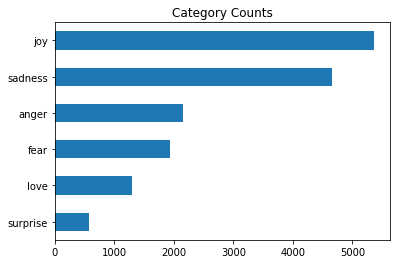

In [18]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

We can see that the dataset is heavily imbalanced; the joy and sadness classes appear
frequently whereas love and sadness are about 5-10 times rarer.

There are several ways to
deal with imbalanced data such as resampling the minority or majority classes.

Alternatively, we can also weight the loss function to account for the underrepresented classes.

###How Long Are Our Tweets?

Transformer models have a maximum input sequence length that is referred to as the maximum context size. 

For most applications with BERT, the maximum context size is 512 tokens, where
a token is defined by the choice of tokenizer and can be a word, subword, or character. 

Let’s make a rough estimate of our tweet lengths per emotion by looking at the distribution of words per tweet:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


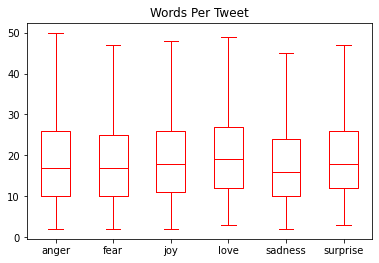

In [19]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="red", )
plt.suptitle("")
plt.xlabel("");

From the plot we see that for each emotion, most tweets are around 15 words long and the
longest tweets are well below BERT’s maximum context size of 512 tokens. 

Texts that are
longer than a model’s context window need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information. 

Let’s now figure out how we can
convert these raw texts into a format suitable for Transformers!

##Tokenization and Vectorization

Transformer models like BERT cannot receive raw strings as input; instead they assume the
text has been tokenized into numerical vectors. Tokenization is the step of breaking down a
string into the atomic units used in the model. 

There are several tokenization strategies one can
adopt and the optimal splitting of words in sub-units is usually learned from the corpus.

###Using Pretrained Tokenizers

We’ve noted that loading the right pretrained tokenizer for a given pretrained model is crucial
to getting sensible results. 

The Transformers library provides a convenient
`from_pretrained` function that can be used to load both objects, either from the Hugging Face Model Hub or from a local path.

To build our emotion detector we’ll use a BERT variant called DistilBERT, which is a
downscaled version of the original BERT model. The main advantage of this model is that it
achieves comparable performance to BERT while being significantly smaller and more
efficient.

Let’s get started by loading the tokenizer for the DistilBERT model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

We can examine a few attributes of the tokenizer such as the vocabulary size:

In [21]:
tokenizer.vocab_size

30522

We can also look at the special tokens used by the tokenizer, which differ from model to model.

For example, BERT uses the `[MASK]` token for the primary objective of masked language
modeling and the `[CLS]` and `[SEP]` tokens for the secondary pretraining objective of
predicting if two sentences are consecutive:

In [22]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

Furthermore, the tokenizer stores the information of the corresponding model’s maximum
context sizes:

In [23]:
tokenizer.model_max_length

512

###Tokenizing the Whole Dataset

Now that we know how to extract the hidden states for a single string, let’s tokenize the whole
dataset! 

To do this, we can write a simple function that will tokenize our examples

In [24]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

where `padding=True` will pad the examples with zeroes to the longest one in a batch, and
`truncation=True` will truncate the examples to the model’s maximum context size.

Previously, we set the output format of the dataset to "pandas" so that the accessed data is
returned as a DataFrame. 

We don’t need this output format anymore so we can now reset it
as follows:

In [25]:
emotions.reset_format()

By applying the tokenize function on a small set of texts.

In [26]:
tokenize(emotions["train"][:3])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

we see that the result is a dictionary, where each value is a list of lists generated by the
tokenizer. In particular, each sequence in input_ids starts with 101 and ends with 102,
followed by zeroes, corresponding to the `[CLS], [SEP]`, and `[PAD]` tokens respectively:

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/3.png?raw=1' width='800'/>

Also note that in addition to returning the encoded tweets as input_ids, the tokenizer also
returns list of attention_mask arrays. This is because we do not want the model to get
confused by the additional padding tokens, so the attention mask allows the model to ignore the
padded parts of the input.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/4.png?raw=1' width='800'/>

>For each batch, the input sequences are padded to the maximum sequence length in the batch. The attention mask is used in the model to ignore the padded areas of the input tensors.

To apply our tokenize function to the whole emotions corpus, we’ll use the
DatasetDict.map function. 

This will apply tokenize across all the splits in the corpus,
so our training, validation and test data will be preprocessed in a single line of code:

In [ ]:
# batch_size=None applies our tokenize function in one single batch and ensures that the input tensors and attention masks have the same shape globally
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

By default, `DatasetDict.map` operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches, while `batch_size=None` applies our tokenize function in one single batch and ensures that the input tensors and attention masks have the same shape globally. 

We can see that this operation has added two new features to the dataset: `input_ids` and the `attention mask`.

In [28]:
emotions_encoded["train"].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [29]:
emotions_encoded["train"].features["attention_mask"]

Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)

In [30]:
emotions_encoded["train"].features["input_ids"]

Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)

In [31]:
emotions_encoded["train"].features["label"]

ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)

In [32]:
emotions_encoded["train"].features["text"]

Value(dtype='string', id=None)

###From Input IDs to Hidden States

Now that we have converted our tweets to numerical inputs, the next step is to extract the last hidden states so that we can feed them to a classifier. 

If we had a single example we could simply pass the `input_ids` and `attention_mask` to the model as follows:

```python
hidden_states = model(input_ids, attention_mask)
```

but what we really want are the hidden states across the whole dataset. For this, we can use the `DatasetDict.map` function again! 

Let’s define a `forward_pass` function that takes a
batch of input IDs and attention masks, feeds them to the model, and adds a new
`hidden_state` feature to our batch:

In [45]:
def forward_pass(batch):
  input_ids = torch.tensor(batch["input_ids"]).to(device)
  attention_mask = torch.tensor(batch["attention_mask"]).to(device)

  with torch.no_grad():
    last_hidden_state = model(input_ids, attention_mask).last_hidden_state
    last_hidden_state = last_hidden_state.cpu().numpy()

  # Use average of unmasked hidden states for classification
  lhs_shape = last_hidden_state.shape
  boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
  boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
  boolean_mask = boolean_mask.reshape(lhs_shape)
  masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
  batch["hidden_state"] = masked_mean.data

  return batch

In [ ]:
model = AutoModel.from_pretrained(model_name).to(device)

In [ ]:
emotions_encoded = emotions_encoded.map(forward_pass, batched=True, batch_size=16)

As before, the application of `DatasetDict.map` has added a new `hidden_state` feature to our dataset:

In [50]:
emotions_encoded["train"].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'hidden_state': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [51]:
labels_name= emotions_encoded["train"].features["label"]
labels_name.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

###Creating a Feature Matrix

The preprocessed dataset now contains all the information we need to train a clasifier on it. We
will use the hidden states as input features and the labels as targets. 

We can easily create the
corresponding arrays in the well known Scikit-Learn format as follows:

In [53]:
x_train = np.array(emotions_encoded["train"]["hidden_state"])
x_valid = np.array(emotions_encoded["validation"]["hidden_state"])

y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])

x_train.shape, x_valid.shape

((16000, 768), (2000, 768))

###Dimensionality Reduction with UMAP

Before we train a model on the hidden states, it is good practice to perform a sanity check that
they provide a useful representation of the emotions we want to classify. 

Since visualising the hidden states in 768 dimensions is tricky to say the least, we’ll use the powerful UMAP algorithm to project the vectors down to 2D. 

Since UMAP works best when the features are scaled to lie in the `[0,1]` interval, we’ll first apply a MinMaxScaler and then use UMAP to
reduce the hidden states:

In [54]:
x_scaled = MinMaxScaler().fit_transform(x_train)
mapper = umap.UMAP(n_components=2, metric="cosine").fit(x_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train

df_emb.head()

,X,Y,label
0,6.248400,4.642050,0
1,1.292773,4.426934,0
2,5.448877,1.858183,3
3,2.250811,2.956772,2
4,0.672228,6.810980,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! 

Let us investigate the compressed data a little bit further and
plot the density of points for each category separately:

In [55]:
labels= emotions_encoded["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

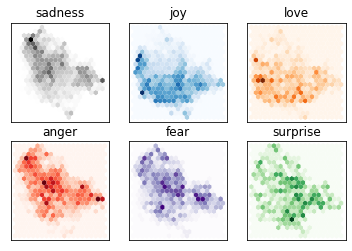

In [56]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels= emotions_encoded["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

>These are only projections onto a lower dimensional space. Just because some categories overlap does not mean
that they are not separable in the original space. Conversely, if they are separable in the projected space they will
be separable in the original space.

Now there seem to be clearer patterns; the negative feelings such as sadness, anger and
fear all occupy a similar regions with slightly varying distributions. 

On the other hand, joy
and love are well separated from the negative emotions and also share a similar space.

Finally, surprise is scattered all over the place. We hoped for some separation but this in no
way guaranteed since the model was not trained to know the difference between this emotions
but learned them implicitly by predicting missing words.

##Fine-tuning Transformers

Let’s now explore what it takes to fine-tune a Transformer end-to-end. With the fine-tuning
approach we do not use the hidden states as fixed features, but instead train them as shown.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/02-text-classification/images/5.png?raw=1' width='800'/>

This requires the classification head to be differentiable, which is why this method
usually uses a neural network for classification. 

Since we retrain all the DistilBERT parameters,
this approach requires much more compute than the feature extraction approach and typically
requires a GPU.

Since we train the hidden states that serve as inputs to the classification model, we also avoid
the problem of working with data that may not be well suited for the classification task. 

Instead,
the initial hidden states adapt during training to decrease the model loss and thus increase its
performance. If the necessary compute is available, this method is commonly chosen over the
feature-based approach since it usually outperforms it.

We’ll be using the Trainer API from Transformers to simplify the training loop - let’s look at the ingredients we need to set one up!

####Loading a Pretrained Model

The first thing we need is a pretrained `DistilBERT` model like the one we used in the featurebased approach. The only slight modification is that we use the
`AutoModelForSequenceClassification` model instead of `AutoModel`. 

The difference is that the `AutoModelForSequenceClassification` model has a
classification head on top of the model outputs which can be easily trained with the base model.

We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [57]:
num_labels = 6

model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

You will probably see a warning that some parts of the models are randomly initialized. This is
normal since the classification head has not yet been trained.

####Preprocess the Tweets

In addition to the tokenization we also need to set the format of the columns to
`torch.Tensor`. This allows us to train the model without needing to change back and forth
between lists, arrays, and tensors. 

With Datasets we can use the `set_format` function to
change the data type of the columns we wish to keep, while dropping all the rest:

In [58]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

We can see that the samples are now of type `torch.Tensor`:

In [59]:
emotions_encoded["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [60]:
emotions_encoded["train"][1]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

####Define the Performance Metrics

Furthermore, we define some metrics that are monitored during training. This can be any
function that takes a prediction object, that contains the model predictions as well as the correct
labels and returns a dictionary with scalar metric values. 

We will monitor the F1-score and the
accuracy of the model.

In [61]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

####Training the Model

With the dataset and metrics ready we can now instantiate a Trainer class. The main
ingredient here is the TrainingArguments class to specify all the parameters of the
training run, one of which is the output directory for the model checkpoints.

In [62]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,)

With this final ingredient, we can instantiate and finetune
our model with the `Trainer`:

In [63]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500


Step,Training Loss,Validation Loss,Accuracy,F1
250,0.818700,0.321873,0.906000,0.903479
500,0.247500,0.224831,0.924000,0.924199


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/checkpoint-500 (score: 0.924198595718084).


Looking at the logs we can see that our model has an `F1` score on the validation set of around
`92%` - this is a significant improvement over the feature-based approach! 

We can also see that
the best model was saved by running the `evaluate` method:

In [64]:
results = trainer.evaluate()
results

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'epoch': 2.0,
 'eval_accuracy': 0.924,
 'eval_f1': 0.924198595718084,
 'eval_loss': 0.22483114898204803,
 'eval_runtime': 8.6083,
 'eval_samples_per_second': 232.333,
 'eval_steps_per_second': 3.717}

Let’s have a more detailed look at the training metrics by calculating the confusion matrix.

####Visualize the Confusion Matrix

To visualise the confusion matrix, we first need to get the predictions on the validation set. 

The predict function of the Trainer class returns several useful objects we can use for evaluation:

In [65]:
preds_output = trainer.predict(emotions_encoded["validation"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hidden_state, text.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


First, it contains the loss and the metrics we specified earlier:

In [66]:
preds_output.metrics

{'test_accuracy': 0.924,
 'test_f1': 0.924198595718084,
 'test_loss': 0.22483114898204803,
 'test_runtime': 8.4396,
 'test_samples_per_second': 236.979,
 'test_steps_per_second': 3.792}

It also contains the raw predictions for each class. We decode the predictions greedily with an
argmax. 

This yields the predicted label and has the same format as the labels returned by the
Scikit-Learn models in the feature-based approach:

In [67]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions we can plot the confusion matrix again:

In [68]:
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
labels= emotions_encoded["train"].features["label"]
labels.names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
#plot_confusion_matrix(y_preds, y_valid, labels)

Also, looking at the classification report reveals that the model is also performing much better
for minority classes like surprise.

In [69]:
print(classification_report(y_valid, y_preds, target_names=labels.names))

              precision    recall  f1-score   support

     sadness       0.94      0.97      0.96       550
         joy       0.95      0.93      0.94       704
        love       0.81      0.91      0.85       178
       anger       0.94      0.92      0.93       275
        fear       0.87      0.88      0.88       212
    surprise       0.91      0.79      0.85        81

    accuracy                           0.92      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.93      0.92      0.92      2000



##Hyperparameter Optimization